# Sanity Check of FedLeak (CenterCrop Generator), ImageNet(ISLVRC2012).

Here is the sanity check on if FedLeak has been correctly trasferred.

We evaluate it with ***ImageNet(ISLVRC2012)***, with $5$ times sampling batch = $16$, reporting results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from test-set, with `shuffle=True`.
- *Way to report*: PSNRs in $5$ times recovery, including the *max* value and the *median* value.

Codes are aligned with `sanity_check_centercrop_showcase.ipynb`, with `centercrop_generator.py` introduced.

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, argparse, os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

try:
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    os.chdir("..")
    
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from centercrop_generator import FedLeak


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:0")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128))
])

dataset = torchvision.datasets.ImageNet(root="~/data/imagenet/", split="val", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, generator=torch.Generator().manual_seed(seed))
loader_iter = iter(trainloader)

device

device(type='cuda', index=0)

### 🚩 3. Attack for five times

In [3]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

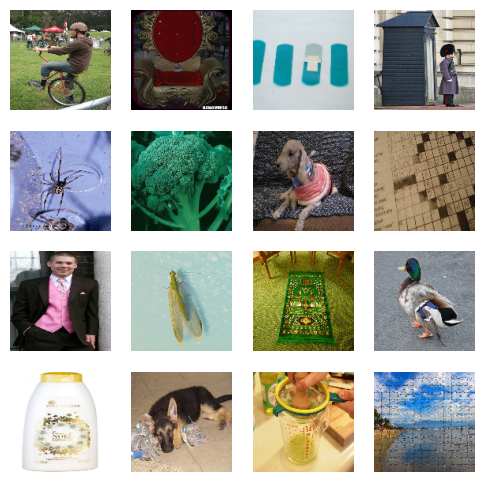

| It: 1 | Loss: -13.8247 | Time:   5.16s |


| It: 1001 | Loss: -61.1351 | Time: 474.75s |


| It: 2001 | Loss: -61.6299 | Time: 473.60s |


| It: 3001 | Loss: -61.7636 | Time: 472.23s |


| It: 4001 | Loss: -61.8390 | Time: 474.68s |


| It: 5001 | Loss: -61.8815 | Time: 473.15s |


| It: 6001 | Loss: -61.9136 | Time: 472.30s |


| It: 7001 | Loss: -61.9364 | Time: 474.06s |


| It: 8001 | Loss: -61.9513 | Time: 473.99s |


| It: 9001 | Loss: -61.9579 | Time: 475.62s |


| It: 1 | Loss: -3.7916 | Time:   0.38s |


| It: 1001 | Loss: -61.2113 | Time: 475.36s |


| It: 2001 | Loss: -61.6569 | Time: 474.82s |


| It: 3001 | Loss: -61.7814 | Time: 474.46s |


| It: 4001 | Loss: -61.8414 | Time: 475.41s |


| It: 5001 | Loss: -61.8816 | Time: 474.27s |


| It: 6001 | Loss: -61.9152 | Time: 474.54s |


| It: 7001 | Loss: -61.9363 | Time: 473.77s |


| It: 8001 | Loss: -61.9504 | Time: 473.10s |


| It: 9001 | Loss: -61.9573 | Time: 472.31s |


| It: 1 | Loss: 0.0490 | Time:   0.39s |


| It: 1001 | Loss: -61.1125 | Time: 473.10s |


| It: 2001 | Loss: -61.6299 | Time: 474.53s |


| It: 3001 | Loss: -61.7677 | Time: 473.41s |


| It: 4001 | Loss: -61.8417 | Time: 472.48s |


| It: 5001 | Loss: -61.8836 | Time: 473.93s |


| It: 6001 | Loss: -61.9147 | Time: 491.94s |


| It: 7001 | Loss: -61.9382 | Time: 566.82s |


| It: 8001 | Loss: -61.9528 | Time: 566.87s |


| It: 9001 | Loss: -61.9588 | Time: 567.67s |


| It: 1 | Loss: -8.6682 | Time:   0.45s |


| It: 1001 | Loss: -60.8535 | Time: 566.91s |


| It: 2001 | Loss: -61.5839 | Time: 566.45s |


| It: 3001 | Loss: -61.7473 | Time: 566.05s |


| It: 4001 | Loss: -61.8242 | Time: 565.11s |


| It: 5001 | Loss: -61.8745 | Time: 566.26s |


| It: 6001 | Loss: -61.9085 | Time: 567.20s |


| It: 7001 | Loss: -61.9337 | Time: 566.80s |


| It: 8001 | Loss: -61.9483 | Time: 566.40s |


| It: 9001 | Loss: -61.9554 | Time: 568.73s |


| It: 1 | Loss: -10.4726 | Time:   0.48s |


| It: 1001 | Loss: -61.1801 | Time: 566.83s |


| It: 2001 | Loss: -61.6636 | Time: 568.75s |


| It: 3001 | Loss: -61.7850 | Time: 569.38s |


| It: 4001 | Loss: -61.8453 | Time: 570.51s |


| It: 5001 | Loss: -61.8879 | Time: 571.07s |


| It: 6001 | Loss: -61.9186 | Time: 569.20s |


| It: 7001 | Loss: -61.9406 | Time: 569.09s |


| It: 8001 | Loss: -61.9536 | Time: 569.40s |


| It: 9001 | Loss: -61.9600 | Time: 568.79s |


BEST PSNR: 21.2376
MEDIAN PSNR: 20.7117
ALL PSNR: [20.5882, 21.2376, 20.4596, 20.7046, 20.7046]


<Figure size 400x300 with 0 Axes>

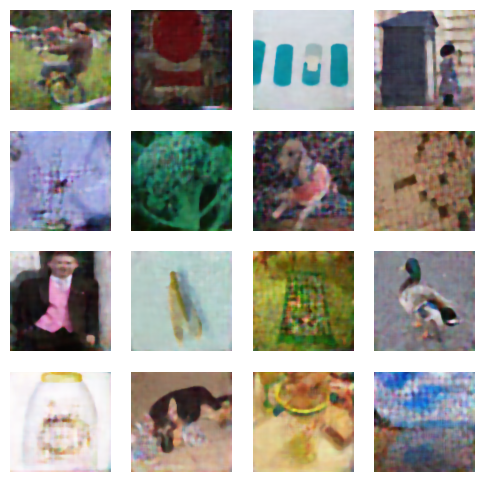

In [4]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

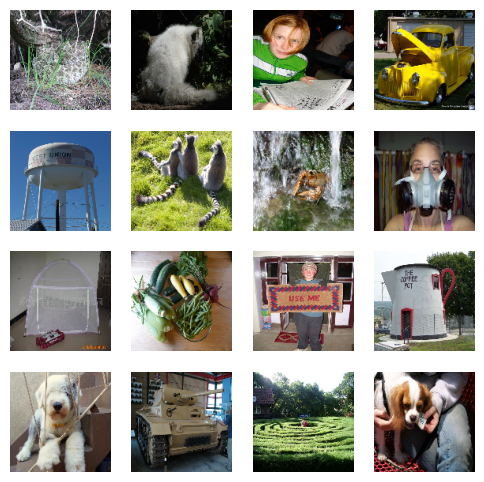

| It: 1 | Loss: -5.7173 | Time:   0.46s |


| It: 1001 | Loss: -61.0693 | Time: 569.66s |


| It: 2001 | Loss: -61.6493 | Time: 568.53s |


| It: 3001 | Loss: -61.7841 | Time: 568.35s |


| It: 4001 | Loss: -61.8434 | Time: 567.04s |


| It: 5001 | Loss: -61.8897 | Time: 565.67s |


| It: 6001 | Loss: -61.9197 | Time: 568.49s |


| It: 7001 | Loss: -61.9417 | Time: 567.66s |


| It: 8001 | Loss: -61.9558 | Time: 565.04s |


| It: 9001 | Loss: -61.9619 | Time: 568.57s |


| It: 1 | Loss: -9.1944 | Time:   0.43s |


| It: 1001 | Loss: -61.0856 | Time: 569.36s |


| It: 2001 | Loss: -61.6369 | Time: 569.19s |


| It: 3001 | Loss: -61.7774 | Time: 566.66s |


| It: 4001 | Loss: -61.8432 | Time: 568.27s |


| It: 5001 | Loss: -61.8850 | Time: 568.00s |


| It: 6001 | Loss: -61.9171 | Time: 565.45s |


| It: 7001 | Loss: -61.9401 | Time: 568.13s |


| It: 8001 | Loss: -61.9545 | Time: 568.25s |


| It: 9001 | Loss: -61.9611 | Time: 568.86s |


| It: 1 | Loss: -7.8005 | Time:   0.47s |


| It: 1001 | Loss: -61.2211 | Time: 570.26s |


| It: 2001 | Loss: -61.6879 | Time: 374.57s |


| It: 3001 | Loss: -61.8011 | Time: 352.67s |


| It: 4001 | Loss: -61.8592 | Time: 359.47s |


| It: 5001 | Loss: -61.8971 | Time: 359.23s |


| It: 6001 | Loss: -61.9263 | Time: 358.79s |


| It: 7001 | Loss: -61.9465 | Time: 357.24s |


| It: 8001 | Loss: -61.9597 | Time: 357.83s |


| It: 9001 | Loss: -61.9656 | Time: 356.05s |


| It: 1 | Loss: -12.7353 | Time:   0.39s |


| It: 1001 | Loss: -60.9876 | Time: 350.94s |


| It: 2001 | Loss: -61.6262 | Time: 358.02s |


| It: 3001 | Loss: -61.7641 | Time: 354.32s |


| It: 4001 | Loss: -61.8353 | Time: 357.83s |


| It: 5001 | Loss: -61.8812 | Time: 351.41s |


| It: 6001 | Loss: -61.9145 | Time: 357.75s |


| It: 7001 | Loss: -61.9377 | Time: 358.88s |


| It: 8001 | Loss: -61.9522 | Time: 359.29s |


| It: 9001 | Loss: -61.9585 | Time: 353.00s |


| It: 1 | Loss: -5.5671 | Time:   0.35s |


| It: 1001 | Loss: -60.9915 | Time: 358.39s |


| It: 2001 | Loss: -61.6322 | Time: 354.03s |


| It: 3001 | Loss: -61.7687 | Time: 357.14s |


| It: 4001 | Loss: -61.8397 | Time: 359.32s |


| It: 5001 | Loss: -61.8817 | Time: 357.77s |


| It: 6001 | Loss: -61.9158 | Time: 354.38s |


| It: 7001 | Loss: -61.9393 | Time: 355.61s |


| It: 8001 | Loss: -61.9540 | Time: 356.19s |


| It: 9001 | Loss: -61.9605 | Time: 358.09s |


BEST PSNR: 19.7396
MEDIAN PSNR: 19.4875
ALL PSNR: [19.7396, 19.6569, 19.6174, 18.7156, 18.7156]


<Figure size 400x300 with 0 Axes>

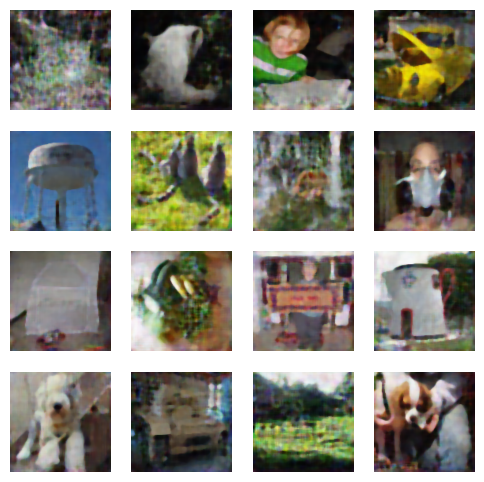

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

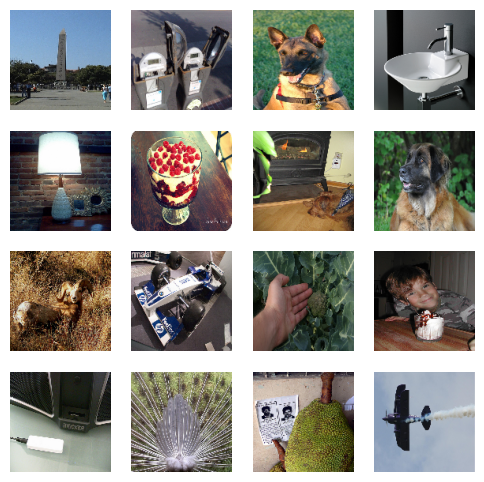

| It: 1 | Loss: -5.1629 | Time:   0.38s |


| It: 1001 | Loss: -60.9393 | Time: 351.45s |


| It: 2001 | Loss: -61.5654 | Time: 345.53s |


| It: 3001 | Loss: -61.7250 | Time: 355.33s |


| It: 4001 | Loss: -61.8052 | Time: 358.50s |


| It: 5001 | Loss: -61.8560 | Time: 355.77s |


| It: 6001 | Loss: -61.8987 | Time: 354.68s |


| It: 7001 | Loss: -61.9258 | Time: 353.32s |


| It: 8001 | Loss: -61.9436 | Time: 352.83s |


| It: 9001 | Loss: -61.9515 | Time: 361.51s |


| It: 1 | Loss: -3.9535 | Time:   0.37s |


| It: 1001 | Loss: -60.9334 | Time: 356.77s |


| It: 2001 | Loss: -61.5525 | Time: 357.63s |


| It: 3001 | Loss: -61.7149 | Time: 356.57s |


| It: 4001 | Loss: -61.7966 | Time: 354.88s |


| It: 5001 | Loss: -61.8517 | Time: 358.37s |


| It: 6001 | Loss: -61.8928 | Time: 358.00s |


| It: 7001 | Loss: -61.9230 | Time: 358.32s |


| It: 8001 | Loss: -61.9406 | Time: 357.01s |


| It: 9001 | Loss: -61.9489 | Time: 357.16s |


| It: 1 | Loss: -8.4027 | Time:   0.38s |


| It: 1001 | Loss: -60.8818 | Time: 357.87s |


| It: 2001 | Loss: -61.5422 | Time: 357.26s |


| It: 3001 | Loss: -61.7192 | Time: 357.25s |


| It: 4001 | Loss: -61.7908 | Time: 357.50s |


| It: 5001 | Loss: -61.8476 | Time: 359.23s |


| It: 6001 | Loss: -61.8884 | Time: 356.95s |


| It: 7001 | Loss: -61.9166 | Time: 356.58s |


| It: 8001 | Loss: -61.9358 | Time: 356.28s |


| It: 9001 | Loss: -61.9443 | Time: 357.28s |


| It: 1 | Loss: -13.6469 | Time:   0.35s |


| It: 1001 | Loss: -60.7909 | Time: 354.59s |


| It: 2001 | Loss: -61.4963 | Time: 356.12s |


| It: 3001 | Loss: -61.6824 | Time: 355.84s |


| It: 4001 | Loss: -61.7778 | Time: 355.80s |


| It: 5001 | Loss: -61.8373 | Time: 357.32s |


| It: 6001 | Loss: -61.8831 | Time: 356.32s |


| It: 7001 | Loss: -61.9156 | Time: 355.65s |


| It: 8001 | Loss: -61.9352 | Time: 356.75s |


| It: 9001 | Loss: -61.9445 | Time: 349.59s |


| It: 1 | Loss: -6.1750 | Time:   0.38s |


| It: 1001 | Loss: -60.8158 | Time: 356.37s |


| It: 2001 | Loss: -61.5480 | Time: 357.90s |


| It: 3001 | Loss: -61.7147 | Time: 357.21s |


| It: 4001 | Loss: -61.8028 | Time: 357.20s |


| It: 5001 | Loss: -61.8569 | Time: 357.29s |


| It: 6001 | Loss: -61.8977 | Time: 354.08s |


| It: 7001 | Loss: -61.9273 | Time: 356.74s |


| It: 8001 | Loss: -61.9445 | Time: 356.89s |


| It: 9001 | Loss: -61.9526 | Time: 360.52s |


BEST PSNR: 20.2489
MEDIAN PSNR: 19.9870
ALL PSNR: [19.8675, 20.2489, 19.3958, 20.1809, 20.1809]


<Figure size 400x300 with 0 Axes>

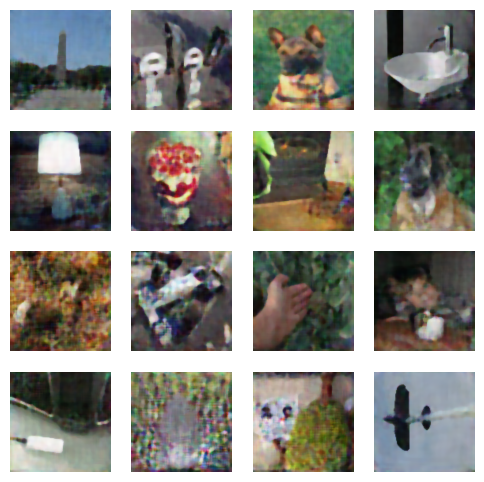

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

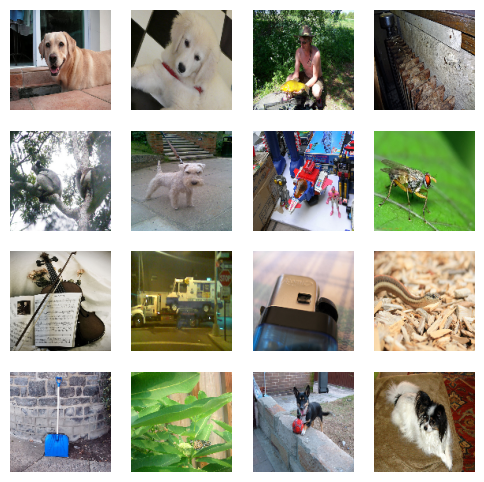

| It: 1 | Loss: -5.8368 | Time:   0.37s |


| It: 1001 | Loss: -61.1599 | Time: 360.89s |


| It: 2001 | Loss: -61.6705 | Time: 363.34s |


| It: 3001 | Loss: -61.7940 | Time: 359.46s |


| It: 4001 | Loss: -61.8587 | Time: 361.08s |


| It: 5001 | Loss: -61.8979 | Time: 359.87s |


| It: 6001 | Loss: -61.9273 | Time: 359.72s |


| It: 7001 | Loss: -61.9470 | Time: 364.68s |


| It: 8001 | Loss: -61.9601 | Time: 366.78s |


| It: 9001 | Loss: -61.9656 | Time: 366.01s |


| It: 1 | Loss: -3.2258 | Time:   0.38s |


| It: 1001 | Loss: -61.4008 | Time: 364.53s |


| It: 2001 | Loss: -61.7286 | Time: 366.46s |


| It: 3001 | Loss: -61.8228 | Time: 365.46s |


| It: 4001 | Loss: -61.8710 | Time: 365.21s |


| It: 5001 | Loss: -61.9065 | Time: 360.85s |


| It: 6001 | Loss: -61.9341 | Time: 356.35s |


| It: 7001 | Loss: -61.9526 | Time: 354.85s |


| It: 8001 | Loss: -61.9635 | Time: 354.47s |


| It: 9001 | Loss: -61.9686 | Time: 355.06s |


| It: 1 | Loss: -4.0968 | Time:   0.39s |


| It: 1001 | Loss: -60.9789 | Time: 354.46s |


| It: 2001 | Loss: -61.6552 | Time: 351.94s |


| It: 3001 | Loss: -61.7881 | Time: 353.38s |


| It: 4001 | Loss: -61.8531 | Time: 354.72s |


| It: 5001 | Loss: -61.8944 | Time: 355.20s |


| It: 6001 | Loss: -61.9247 | Time: 354.77s |


| It: 7001 | Loss: -61.9465 | Time: 354.61s |


| It: 8001 | Loss: -61.9591 | Time: 352.07s |


| It: 9001 | Loss: -61.9650 | Time: 352.53s |


| It: 1 | Loss: -16.8484 | Time:   0.31s |


| It: 1001 | Loss: -61.2051 | Time: 355.44s |


| It: 2001 | Loss: -61.6863 | Time: 354.03s |


| It: 3001 | Loss: -61.7999 | Time: 353.60s |


| It: 4001 | Loss: -61.8590 | Time: 354.32s |


| It: 5001 | Loss: -61.8992 | Time: 352.74s |


| It: 6001 | Loss: -61.9285 | Time: 351.87s |


| It: 7001 | Loss: -61.9482 | Time: 354.54s |


| It: 8001 | Loss: -61.9600 | Time: 351.09s |


| It: 9001 | Loss: -61.9653 | Time: 352.41s |


| It: 1 | Loss: -13.0008 | Time:   0.37s |


| It: 1001 | Loss: -61.1879 | Time: 352.68s |


| It: 2001 | Loss: -61.6786 | Time: 354.95s |


| It: 3001 | Loss: -61.8011 | Time: 352.92s |


| It: 4001 | Loss: -61.8618 | Time: 354.24s |


| It: 5001 | Loss: -61.8979 | Time: 354.53s |


| It: 6001 | Loss: -61.9285 | Time: 353.07s |


| It: 7001 | Loss: -61.9467 | Time: 356.70s |


| It: 8001 | Loss: -61.9596 | Time: 349.49s |


| It: 9001 | Loss: -61.9651 | Time: 354.52s |


BEST PSNR: 20.5172
MEDIAN PSNR: 19.8738
ALL PSNR: [19.1547, 20.5172, 19.8295, 19.4913, 19.4913]


<Figure size 400x300 with 0 Axes>

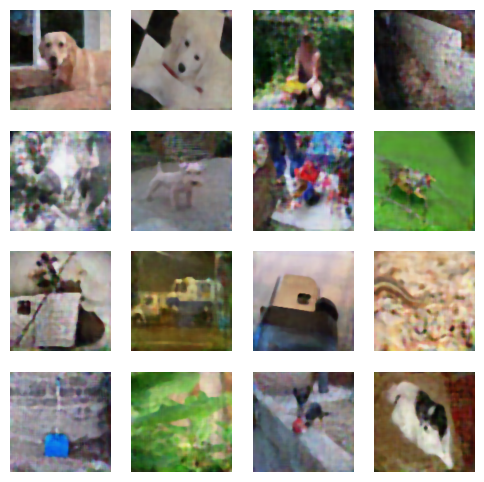

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

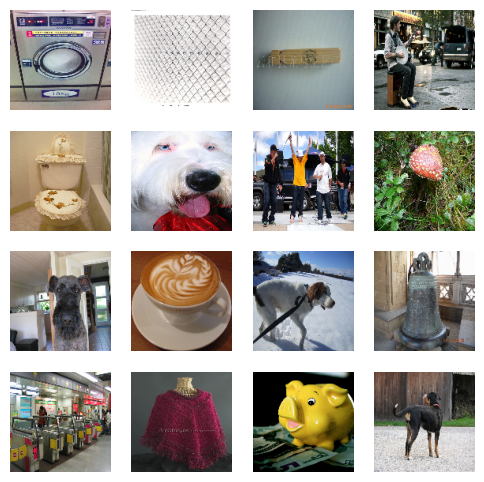

| It: 1 | Loss: -7.5424 | Time:   0.38s |


| It: 1001 | Loss: -60.8703 | Time: 355.40s |


| It: 2001 | Loss: -61.6227 | Time: 351.27s |


| It: 3001 | Loss: -61.7686 | Time: 353.45s |


| It: 4001 | Loss: -61.8351 | Time: 350.55s |


| It: 5001 | Loss: -61.8829 | Time: 355.30s |


| It: 6001 | Loss: -61.9152 | Time: 353.66s |


| It: 7001 | Loss: -61.9385 | Time: 352.26s |


| It: 8001 | Loss: -61.9522 | Time: 354.47s |


| It: 9001 | Loss: -61.9585 | Time: 354.71s |


| It: 1 | Loss: -12.9513 | Time:   0.37s |


| It: 1001 | Loss: -61.1097 | Time: 355.23s |


| It: 2001 | Loss: -61.6581 | Time: 355.34s |


| It: 3001 | Loss: -61.7799 | Time: 356.28s |


| It: 4001 | Loss: -61.8487 | Time: 355.86s |


| It: 5001 | Loss: -61.8902 | Time: 357.27s |


| It: 6001 | Loss: -61.9203 | Time: 354.76s |


| It: 7001 | Loss: -61.9419 | Time: 353.45s |


| It: 8001 | Loss: -61.9547 | Time: 354.74s |


| It: 9001 | Loss: -61.9610 | Time: 348.75s |


| It: 1 | Loss: -11.7838 | Time:   0.38s |


| It: 1001 | Loss: -60.9771 | Time: 355.18s |


| It: 2001 | Loss: -61.6353 | Time: 352.65s |


| It: 3001 | Loss: -61.7716 | Time: 353.92s |


| It: 4001 | Loss: -61.8413 | Time: 348.77s |


| It: 5001 | Loss: -61.8856 | Time: 355.17s |


| It: 6001 | Loss: -61.9174 | Time: 355.71s |


| It: 7001 | Loss: -61.9399 | Time: 354.96s |


| It: 8001 | Loss: -61.9532 | Time: 357.13s |


| It: 9001 | Loss: -61.9593 | Time: 353.52s |


| It: 1 | Loss: -8.7652 | Time:   0.37s |


| It: 1001 | Loss: -60.4914 | Time: 355.54s |


| It: 2001 | Loss: -61.4952 | Time: 356.05s |


| It: 3001 | Loss: -61.7194 | Time: 352.29s |


| It: 4001 | Loss: -61.8129 | Time: 345.75s |


| It: 5001 | Loss: -61.8675 | Time: 355.07s |


| It: 6001 | Loss: -61.9051 | Time: 352.52s |


| It: 7001 | Loss: -61.9299 | Time: 355.96s |


| It: 8001 | Loss: -61.9470 | Time: 350.88s |


| It: 9001 | Loss: -61.9542 | Time: 352.90s |


| It: 1 | Loss: -8.9639 | Time:   0.37s |


| It: 1001 | Loss: -61.0443 | Time: 354.73s |


| It: 2001 | Loss: -61.6401 | Time: 354.18s |


| It: 3001 | Loss: -61.7827 | Time: 354.33s |


| It: 4001 | Loss: -61.8466 | Time: 356.47s |


| It: 5001 | Loss: -61.8891 | Time: 353.22s |


| It: 6001 | Loss: -61.9200 | Time: 354.62s |


| It: 7001 | Loss: -61.9424 | Time: 354.48s |


| It: 8001 | Loss: -61.9557 | Time: 355.69s |


| It: 9001 | Loss: -61.9613 | Time: 353.78s |


BEST PSNR: 19.6452
MEDIAN PSNR: 19.3072
ALL PSNR: [19.6452, 19.2868, 19.3409, 19.1199, 19.1199]


<Figure size 400x300 with 0 Axes>

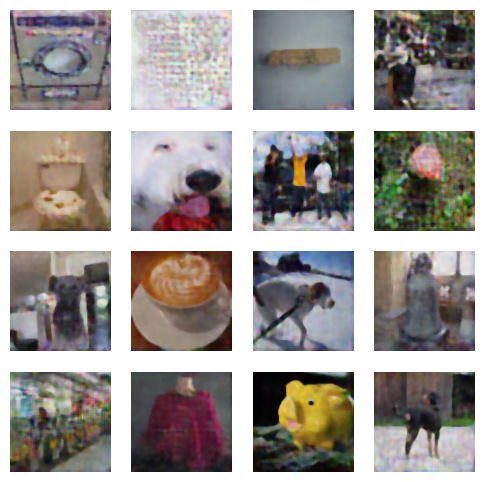

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)